### Prologue
Prepare the notebook for inline plotting<br>
Load required libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [1]:
from IPython.display import Image
%matplotlib inline

# experimental script
import json
import pickle
from forest_surveyor import p_count
from forest_surveyor.datasets import adult_data
from forest_surveyor.structures import forest_walker, batch_getter, rule_accumulator
from forest_surveyor.routines import tune_rf_mp, tune_rf, train_rf, evaluate_model, run_batches, forest_survey, cor_incor_forest_survey
from forest_surveyor.plotting import log_ratio_plot, plot_mean_path_lengths, plot_varimp, plot_feature_stats, rule_profile_plots

Best OOB Cohen's Kappa during tuning: 0.9881
Best parameters: {'min_samples_leaf': 1, 'n_estimators': 1000, 'max_depth': 16}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model
Cohen's Kappa on unseen instances: 0.5903
Confusion matrix, without normalization
[[10681   485]
 [ 1479  2008]]


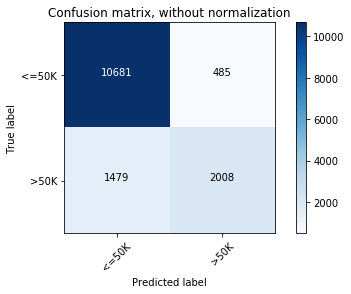

Normalized confusion matrix
[[0.96 0.04]
 [0.42 0.58]]


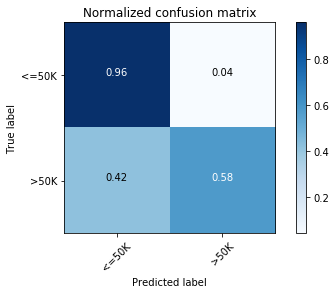

In [26]:
# load a data set
mydata = adult_data()

# train test split
tt = mydata.tt_split()

################ PARAMETER TUNING ###################
############# Only run when required ################
#####################################################

### params = tune_rf(tt['X_train_enc'], tt['y_train'],
###  save_path = mydata.pickle_path(),
###  random_state=mydata.random_state)

#####################################################
#####################################################
#####################################################

# load previously tuned parameters
with open(mydata.pickle_path('params.json'), 'r') as infile:
    params = json.load(infile)

# train a rf model
rf, enc_rf = train_rf(X=tt['X_train_enc'], y=tt['y_train'],
 params=params,
 encoder=tt['encoder'],
 random_state=mydata.random_state)

# only in interactive mode - evaluate and plot the confusion matrix
evaluate_model(prediction_model=enc_rf, X=tt['X_test'], y=tt['y_test'], class_names=mydata.class_names)

In [27]:
# fit the forest_walker
f_walker = forest_walker(forest = rf,
 features=mydata.onehot_features,
 encoder=tt['encoder'],
 prediction_model=enc_rf)

# Part 1. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [4]:
# run the full forest survey
tt_correct_stats, tt_incorrect_stats = cor_incor_forest_survey(
 f_walker = f_walker, X=tt['X_test'], y=tt['y_test'])

C:\dev\study\python\interpret_basics2\forest_surveyor\structures.py:438: RuntimeWarning: Mean of empty slice
  statistics['m_feature_depth'] = np.mean(np.nanmean(feature_depth_lab, axis = 1), axis = 0) # mean depth of each feature when it appears
C:\dev\study\python\interpret_basics2\forest_surveyor\structures.py:448: RuntimeWarning: Mean of empty slice
  statistics['sd_feature_depth'] = np.std(np.nanmean(feature_depth_lab, axis = 1), axis = 0, ddof = 1) # sd depth of each feature when it appears
C:\dev\study\python\interpret_basics2\forest_surveyor\structures.py:456: RuntimeWarning: Mean of empty slice
  statistics['se_feature_depth'] = sem(np.nanmean(feature_depth_lab, axis = 1), axis = 0, ddof = 1, nan_policy = 'omit') # se depth of each feature when it appears


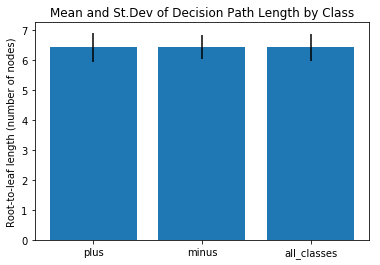

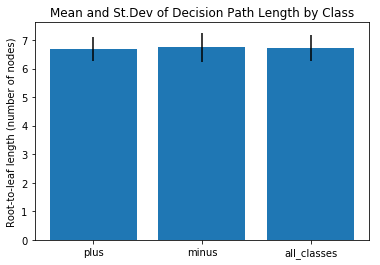

In [5]:
plot_mean_path_lengths(forest_stats=tt_correct_stats, class_names=mydata.class_names)
plot_mean_path_lengths(forest_stats=tt_incorrect_stats, class_names=mydata.class_names)

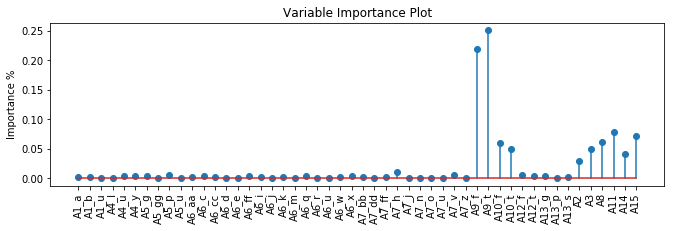

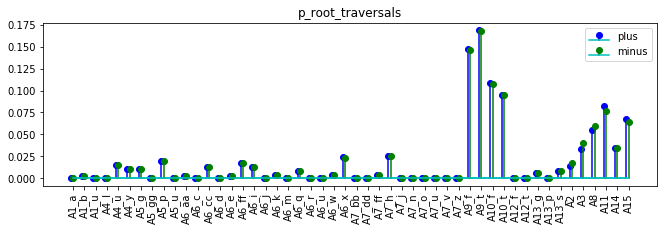

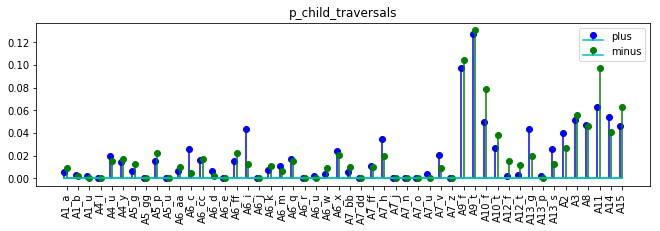

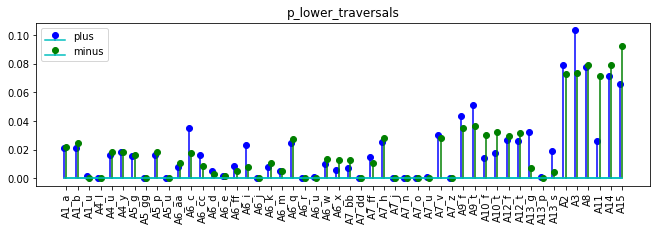

In [6]:
plot_varimp(rf, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_root_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_child_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_lower_traversals', mydata.class_names, mydata.onehot_features)

In [ ]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_child_traversals']
                            , num_err = tt_correct_stats[0]['se_child_traversals']
                            , denom = tt_incorrect_stats[0]['m_child_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_child_traversals']
                            , labels = mydata.onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = mydata.onehot_features
)

# Part 2. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

C:\dev\study\python\interpret_basics2\forest_surveyor\structures.py:251: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(2)
C:\dev\study\python\interpret_basics2\forest_surveyor\structures.py:247: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(2)
C:\Dev\Prog\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


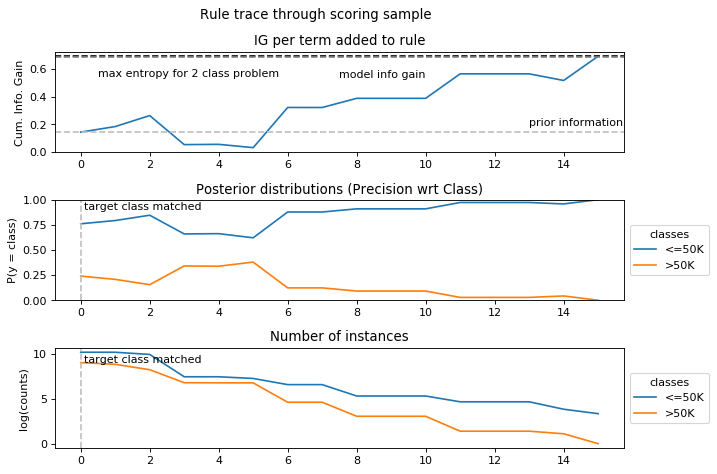

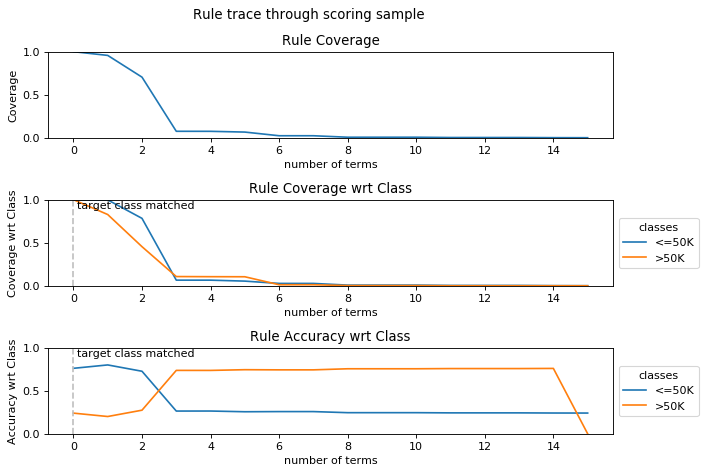

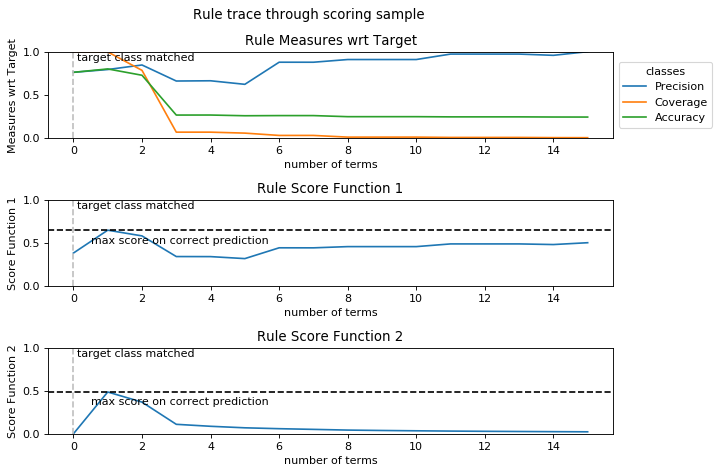

In [28]:
# run the batch based forest walker
getter = batch_getter(instances=tt['X_test'], labels=tt['y_test'])

n = 6
# rule_acc is just the last rule rule_accumulator, results are for the whole batch
rule_acc, results, best_rule = run_batches(f_walker=f_walker,
 getter=getter,
 data_container=mydata,
 sample_instances=tt['X_train_enc'],
 sample_labels=tt['y_train'],
 batch_size = n, n_batches = 1)

[pr for pr in map(mydata.pretty_rule, [best_rule[r][0] for r in range(len(best_rule))])]
rule_profile_plots(rule_acc, mydata.class_names, alpha=0.5)



In [8]:
for r in range(len(best_rule)):
    idx = rule_acc.apply_rule(best_rule[r][0])
    print(p_count(tt['y_train'].loc[idx]))

{'labels': array([0, 1], dtype=int64), 'counts': array([213,  14], dtype=int64), 'p_counts': array([0.93832599, 0.06167401])}
{'labels': array([0, 1], dtype=int64), 'counts': array([213,  14], dtype=int64), 'p_counts': array([0.93832599, 0.06167401])}
{'labels': array([0, 1], dtype=int64), 'counts': array([107, 152], dtype=int64), 'p_counts': array([0.41312741, 0.58687259])}
{'labels': array([0, 1], dtype=int64), 'counts': array([186,   3], dtype=int64), 'p_counts': array([0.98412698, 0.01587302])}
{'labels': array([0, 1], dtype=int64), 'counts': array([45, 72], dtype=int64), 'p_counts': array([0.38461538, 0.61538462])}


# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [ ]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

In [ ]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
interp = interp.sort_values('bad', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

## LIME

In [ ]:
# basic setup
import lime
import lime.lime_tabular as limtab

np.random.seed(seed)

explainer = limtab.LimeTabularExplainer(training_data=np.array(X_train_enc.todense())
                                        , feature_names=onehot_features
                                        , training_labels=y_train
                                        , class_names=class_names
                                        , categorical_features=range(len(onehot_features))
                                        , categorical_names=onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
                                 , rf.predict_proba
                                 , top_labels=4)

In [ ]:
fig = exp.as_pyplot_figure(label=pred_class_code)

exp.as_list(label=pred_class_code)

In [ ]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [ ]:
exp.show_in_notebook()

In [2]:
%run whiteboxing_exp1.py

12 runs to do

starting new run at: Sat Mar 31 10:42:28 2018
{'min_samples_leaf': 1, 'max_depth': 8, 'n_estimators': 500}
ending run at: Sat Mar 31 10:42:29 2018
completed 1 run(s)

starting new run at: Sat Mar 31 10:42:29 2018
{'min_samples_leaf': 1, 'max_depth': 8, 'n_estimators': 1000}
ending run at: Sat Mar 31 10:42:31 2018
completed 2 run(s)

starting new run at: Sat Mar 31 10:42:31 2018
{'min_samples_leaf': 1, 'max_depth': 8, 'n_estimators': 1500}
ending run at: Sat Mar 31 10:42:36 2018
completed 3 run(s)

starting new run at: Sat Mar 31 10:42:36 2018
{'min_samples_leaf': 5, 'max_depth': 8, 'n_estimators': 500}
ending run at: Sat Mar 31 10:42:37 2018
completed 4 run(s)

starting new run at: Sat Mar 31 10:42:37 2018
{'min_samples_leaf': 5, 'max_depth': 8, 'n_estimators': 1000}
ending run at: Sat Mar 31 10:42:40 2018
completed 5 run(s)

starting new run at: Sat Mar 31 10:42:40 2018
{'min_samples_leaf': 5, 'max_depth': 8, 'n_estimators': 1500}
ending run at: Sat Mar 31 10:42:43 2018

In [3]:
params

,elapsed_time,max_depth,min_samples_leaf,n_estimators,score
3,1.476501,8,5,500,0.867495
9,1.040368,16,5,500,0.865424
6,1.199719,16,1,500,0.865424
4,2.507747,8,5,1000,0.865424
1,2.347375,8,1,1000,0.865424
10,2.229253,16,5,1000,0.865424
5,3.081037,8,5,1500,0.865424
2,4.372752,8,1,1500,0.865424
11,3.095994,16,5,1500,0.865424
7,2.526512,16,1,1000,0.863354
